In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda', index=0)

## Neural Network Model

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_sigmoid_stack = nn.Sequential(
        nn.Linear(1,10),
        nn.Sigmoid(),
        nn.Linear(10,10),
        nn.Sigmoid(),
        nn.Linear(10,1, bias=False)
        )
        
    def forward_propagation(self, x):
        N = self.linear_sigmoid_stack(x)
        return N

In [3]:
def training(x, loss_fn, optimizer):
    x = x.to(device)
    def closure():
        loss = loss_fn(x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    optimizer.step(closure)

## Differential equation
$$\frac{d^2\phi(r)}{dx^2} + \frac{2m}{\hbar^2} \left(E_n - \frac{l(l+1)}{2mr^2}\hbar^2 + V(r) \right)\phi(r) = 0$$ 
Dataset are vectors of domain of differential equation, like the vectors are one-dimentional, the shape of dataset is one by m samples. Trial solution $\phi_t(r) = e^{-\beta r^2}N(x,\vec{p})$, with $\phi(r=0) = 0$ and $\phi(r\rightarrow\infty) = 0$ initial conditions.  

In [4]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=1, bias=False)
  )
)

In [5]:
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01)
global beta 
beta = 1.0
global n 
n = 3.0
global l
l = 0.0
E_n = lambda n: -(1/2)*(1/n)**2
V = lambda r: -1/r
Phi_t = lambda r: torch.exp(-beta*r**2) * model.forward_propagation(r)
f = lambda r, Phi: -2*(E_n(n) - l*(l+1)/(2*r**2) + V(r))*Phi

In [6]:
def loss_fn(r):
    r.requires_grad = True
    outputs = Phi_t(r)
    Phi_t_r = torch.autograd.grad(outputs, r, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    Phi_t_r_r = torch.autograd.grad(Phi_t_r, r, grad_outputs=torch.ones_like(Phi_t_r), create_graph=True)[0]
    return torch.mean((Phi_t_r_r - f(r, outputs))**2)

In [7]:
upper_r = 10
steps = 1000
R_train = torch.Tensor(np.linspace(0.001,upper_r,steps)[:,None])
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n ---------------------- loss: {loss_fn(R_train.to(device))}")
    training(R_train, loss_fn, optimizer)
print("Done!")

Epoch 1
 ---------------------- loss: 1601.7567138671875
Epoch 2
 ---------------------- loss: 1006.8944702148438
Epoch 3
 ---------------------- loss: 558.1441040039062
Epoch 4
 ---------------------- loss: 315.05621337890625
Epoch 5
 ---------------------- loss: 185.66429138183594
Epoch 6
 ---------------------- loss: 112.83679962158203
Epoch 7
 ---------------------- loss: 69.95654296875
Epoch 8
 ---------------------- loss: 43.750858306884766
Epoch 9
 ---------------------- loss: 27.385461807250977
Epoch 10
 ---------------------- loss: 17.133058547973633
Epoch 11
 ---------------------- loss: 10.726119995117188
Epoch 12
 ---------------------- loss: 6.726688861846924
Epoch 13
 ---------------------- loss: 4.226364612579346
Epoch 14
 ---------------------- loss: 2.657860517501831
Epoch 15
 ---------------------- loss: 1.6709280014038086
Epoch 16
 ---------------------- loss: 1.0488251447677612
Epoch 17
 ---------------------- loss: 0.6565285325050354
Epoch 18
 ---------------------

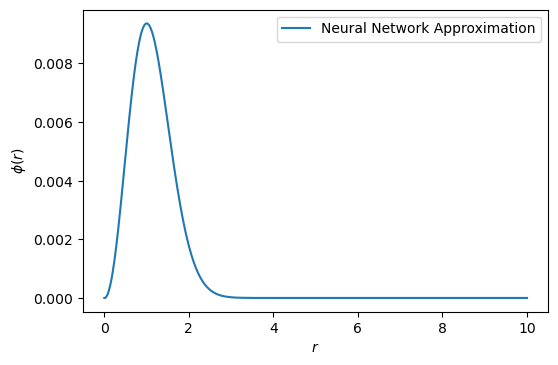

In [8]:
rr = np.linspace(0.001, upper_r, steps)[:,None]

with torch.no_grad():
    RR = rr*Phi_t(torch.Tensor(rr).to(device)).cpu().numpy()
#yt = xx**2 + np.exp(-xx**2 / 2)/(1+xx+xx**3)

fig, axs = plt.subplots(dpi=100)
#axs.plot(xx, yt, label="True")
axs.plot(rr, RR, "-", label="Neural Network Approximation")
axs.set_xlabel("$r$")
axs.set_ylabel("$\phi(r)$")
plt.legend(loc="best")
plt.show()